In [1]:
%autosave 300
%autoreload 2
%reload_ext autoreload
%config Completer.use_jedi = False

Autosaving every 300 seconds


In [2]:
import os

os.chdir(
    r"/home/azureuser/cloudfiles/code/Users/soutrik.chowdhury/abi_genai_bert_classifier"
)

In [27]:
from src.utils.model_helpers import (
    set_seed,
    plot_loss_accuracy,
    get_device,
)
from src.preprocess import data_preprocess
from src.settings import (
    DataSettings,
    env_settings,
    ModelSettings,
    TokenizerSettings,
    AzureblobSettings,
    LoggerSettings
)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.pretrained_model import tokenizer, pretrained_model
from src.dataloader import create_data_loader
from src.model import BertSentimentClassifier, BertSentimentClassifierAdvanced
from src.trainer import train_module, test_module, training_drivers, get_predictions
import json
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
)
from src.utils.azure_connector import AzureBlobConnection
from src.utils.logger import setup_logging # type: ignore


sns.set(style="whitegrid", palette="muted", font_scale=1.2)
HAPPY_COLORS_PALETTE = [
    "#01BEFE",
    "#FFDD00",
    "#FF7D00",
    "#FF006D",
    "#ADFF02",
    "#8F00FF",
]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

In [4]:
logger = setup_logging(
            logger_name=LoggerSettings().logger_name,
            log_file='ModelTrainEval.log',
            log_level=LoggerSettings().log_level,
        )

In [5]:
logger.info("Consolidating all the syntesized files")
folder_path = os.path.join(os.getcwd(), DataSettings().data_path)
csv_files = [file for file in os.listdir(folder_path) if file.endswith(".csv")]
concatenated_df = pd.concat(
    (pd.read_csv(os.path.join(folder_path, file)) for file in csv_files),
    ignore_index=True,
)

2024-04-03 17:36:17,782 - custom_logger - INFO - Consolidating all the syntesized files


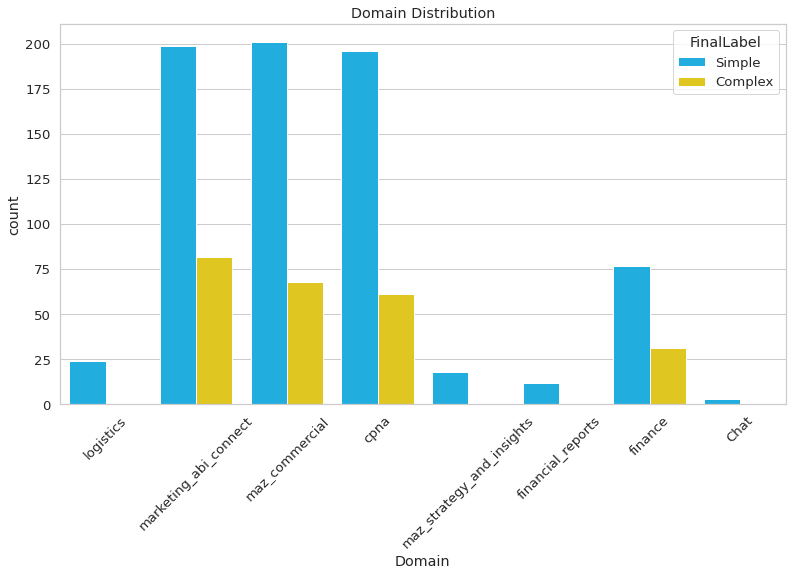

In [6]:
# check the distribution of the labels
plt.figure(figsize=(13, 7))
sns.countplot(data=concatenated_df, x='Domain', hue='FinalLabel')
plt.xticks(rotation=45)
plt.title('Domain Distribution')
plt.show()
plt.close()

In [7]:
train_df, test_df = data_preprocess(
    concatenated_df, DataSettings().evaluation_size, ModelSettings().seed
)

Train and test dataframes created with 0.25 with sizes (729, 3) and (243, 3)
proportion of targets in train is 0    0.751715
1    0.248285
Name: FinalLabel, dtype: float64 and in test is 0    0.748971
1    0.251029
Name: FinalLabel, dtype: float64


In [8]:
# train test dataloader
logger.info("Creating train and test dataloaders")
train_loader = create_data_loader(
    question=train_df["Question"].values,
    targets=train_df["FinalLabel"].values,
    max_len=TokenizerSettings().max_length,
    batch_size=TokenizerSettings().batch_size,
    shuffle=True,
    tokenizer=tokenizer,
)
test_loader = create_data_loader(
    question=test_df["Question"].values,
    targets=test_df["FinalLabel"].values,
    max_len=TokenizerSettings().max_length,
    batch_size=TokenizerSettings().batch_size,
    shuffle=False,
    tokenizer=tokenizer,
)

2024-04-03 17:36:18,575 - custom_logger - INFO - Creating train and test dataloaders


In [9]:
# batched of 8 with 128 token size
for train_data in train_loader:
    logger.info(train_data.keys())
    logger.info(f"Shape of the val input ids: {train_data['input_ids'].shape}")
    logger.info(f"Shape of val attention heads: {train_data['attention_mask'].shape}")
    logger.info(f"Shape of val targets:: {train_data['targets'].shape}")
    logger.info("\n")
    break

for test_data in test_loader:
    logger.info(test_data.keys())
    logger.info(f"Shape of the val input ids: {test_data['input_ids'].shape}")
    logger.info(f"Shape of val attention heads: {test_data['attention_mask'].shape}")
    logger.info(f"Shape of val targets:: {test_data['targets'].shape}")
    logger.info("\n")
    break

2024-04-03 17:36:19,139 - custom_logger - INFO - dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
2024-04-03 17:36:19,142 - custom_logger - INFO - Shape of the val input ids: torch.Size([16, 128])
2024-04-03 17:36:19,143 - custom_logger - INFO - Shape of val attention heads: torch.Size([16, 128])
2024-04-03 17:36:19,144 - custom_logger - INFO - Shape of val targets:: torch.Size([16])
2024-04-03 17:36:19,144 - custom_logger - INFO - 

2024-04-03 17:36:19,288 - custom_logger - INFO - dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
2024-04-03 17:36:19,292 - custom_logger - INFO - Shape of the val input ids: torch.Size([16, 128])
2024-04-03 17:36:19,293 - custom_logger - INFO - Shape of val attention heads: torch.Size([16, 128])
2024-04-03 17:36:19,294 - custom_logger - INFO - Shape of val targets:: torch.Size([16])
2024-04-03 17:36:19,295 - custom_logger - INFO - 



In [10]:
set_seed(ModelSettings().seed)
device = get_device()

Random seed set as 71


In [11]:
logger.info("Base Classifier")
bert_base_classifier = BertSentimentClassifier(
    pretrained_model, ModelSettings().num_classes,ModelSettings().drop_out
).to(device)

2024-04-03 17:36:19,418 - custom_logger - INFO - Base Classifier


In [12]:
criterion, optimizer, scheduler, metric, early_stopping = training_drivers(
    bert_base_classifier,
    learning_rate=ModelSettings().learning_rate,
    train_loader=train_loader,
    epochs=ModelSettings().epochs,
    device=device,
    model_name="base_bert_model.pt",
)

In [13]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(ModelSettings().epochs):

    logger.info(f"Epoch {epoch + 1}/{ModelSettings().epochs}")
    logger.info("-" * 10)

    train_losses, train_metrics = train_module(
        model=bert_base_classifier,
        device=device,
        train_dataloader=train_loader,
        optimizer=optimizer,
        criterion=criterion,
        metric=metric,
        scheduler=scheduler,
        train_losses=train_losses,
        train_metrics=train_metrics,
    )

    test_losses, test_metrics = test_module(
        model=bert_base_classifier,
        device=device,
        test_dataloader=test_loader,
        criterion=criterion,
        metric=metric,
        test_losses=test_losses,
        test_metrics=test_metrics,
    )
    scheduler.step()

    logger.info(f"The learing rate is going to be next::{scheduler.get_last_lr()}")

    early_stopping(
        test_losses[-1], bert_base_classifier, epoch
    )  # last recorded test loss to measure the improvement against the prior one
    if early_stopping.early_stop:
        logger.info("Early stopping")
        break

2024-04-03 17:36:19,603 - custom_logger - INFO - Epoch 1/20
2024-04-03 17:36:19,604 - custom_logger - INFO - ----------


Avg Train Loss: 0.39921582052889076 Avg Train Metric: 0.23706791598511778: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:06<00:00,  6.98it/s]


2024-04-03 17:36:26,936 - custom_logger - INFO - The learing rate is going to be next::[1.8978260869565218e-05]


Validation loss decreased (inf --> 0.215540).  Saving model ...
2024-04-03 17:36:30,873 - custom_logger - INFO - Epoch 2/20
2024-04-03 17:36:30,874 - custom_logger - INFO - ----------


Avg Train Loss: 0.16814136501077726 Avg Train Metric: 0.8907055686349454: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:05<00:00,  7.97it/s]


2024-04-03 17:36:37,379 - custom_logger - INFO - The learing rate is going to be next::[1.7956521739130437e-05]


Validation loss decreased (0.215540 --> 0.204043).  Saving model ...
2024-04-03 17:36:41,239 - custom_logger - INFO - Epoch 3/20
2024-04-03 17:36:41,240 - custom_logger - INFO - ----------


Avg Train Loss: 0.09072708557157413 Avg Train Metric: 0.9206207874028579: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:05<00:00,  7.93it/s]


2024-04-03 17:36:47,796 - custom_logger - INFO - The learing rate is going to be next::[1.6934782608695653e-05]
EarlyStopping counter: 1 out of 5
2024-04-03 17:36:47,798 - custom_logger - INFO - Epoch 4/20
2024-04-03 17:36:47,798 - custom_logger - INFO - ----------



Avg Train Loss: 0.0597868627342193 Avg Train Metric: 0.9724389301693958: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:05<00:00,  7.89it/s]

2024-04-03 17:36:54,363 - custom_logger - INFO - The learing rate is going to be next::[1.591304347826087e-05]
EarlyStopping counter: 2 out of 5
2024-04-03 17:36:54,364 - custom_logger - INFO - Epoch 5/20
2024-04-03 17:36:54,365 - custom_logger - INFO - ----------



Avg Train Loss: 0.06395830287415859 Avg Train Metric: 0.9533854049185048: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:05<00:00,  7.98it/s]

2024-04-03 17:37:00,882 - custom_logger - INFO - The learing rate is going to be next::[1.4891304347826087e-05]
EarlyStopping counter: 3 out of 5
2024-04-03 17:37:00,884 - custom_logger - INFO - Epoch 6/20
2024-04-03 17:37:00,884 - custom_logger - INFO - ----------


Avg Train Loss: 0.045718703474647 Avg Train Metric: 0.977759090454682: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:05<00:00,  7.95it/s]


2024-04-03 17:37:07,412 - custom_logger - INFO - The learing rate is going to be next::[1.3869565217391305e-05]
EarlyStopping counter: 4 out of 5
2024-04-03 17:37:07,414 - custom_logger - INFO - Epoch 7/20
2024-04-03 17:37:07,414 - custom_logger - INFO - ----------



Avg Train Loss: 0.03829015642100864 Avg Train Metric: 0.981273555237314: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:05<00:00,  7.99it/s]

2024-04-03 17:37:13,921 - custom_logger - INFO - The learing rate is going to be next::[1.2847826086956523e-05]
EarlyStopping counter: 5 out of 5
2024-04-03 17:37:13,922 - custom_logger - INFO - Early stopping


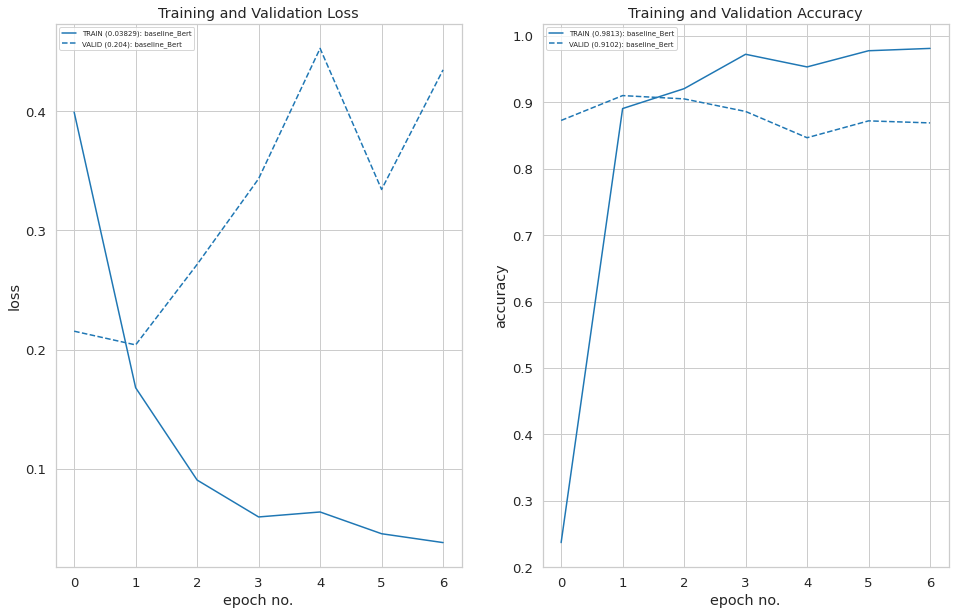

In [14]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['baseline_Bert'],
                   colors=['blue'],
                   loss_legend_loc='upper left',
                   acc_legend_loc='upper left',
                   legend_font=7)

In [15]:
logger.info("Advanced Classifier")
bert_advanced_classifier = BertSentimentClassifierAdvanced(
    bert=pretrained_model,
    n_classes=ModelSettings().num_classes,
    dropout=ModelSettings().drop_out,
).to(device)

2024-04-03 17:37:14,687 - custom_logger - INFO - Advanced Classifier


In [16]:
criterion, optimizer, scheduler, metric, early_stopping = training_drivers(
    bert_advanced_classifier,
    learning_rate=ModelSettings().learning_rate,
    train_loader=train_loader,
    epochs=ModelSettings().epochs,
    device=device,
    model_name="advanced_bert_model.pt",
)

In [17]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(ModelSettings().epochs):

    logger.info(f"Epoch {epoch + 1}/{ModelSettings().epochs}")
    logger.info("-" * 10)

    train_losses, train_metrics = train_module(
        model=bert_advanced_classifier,
        device=device,
        train_dataloader=train_loader,
        optimizer=optimizer,
        criterion=criterion,
        metric=metric,
        scheduler=scheduler,
        train_losses=train_losses,
        train_metrics=train_metrics,
    )

    test_losses, test_metrics = test_module(
        model=bert_advanced_classifier,
        device=device,
        test_dataloader=test_loader,
        criterion=criterion,
        metric=metric,
        test_losses=test_losses,
        test_metrics=test_metrics,
    )
    scheduler.step()

    logger.info(f"The learing rate is going to be next::{scheduler.get_last_lr()}")

    early_stopping(
        test_losses[-1], bert_advanced_classifier, epoch
    )  # last recorded test loss to measure the improvement against the prior one
    if early_stopping.early_stop:
        logger.info("Early stopping")
        break

2024-04-03 17:37:14,829 - custom_logger - INFO - Epoch 1/20
2024-04-03 17:37:14,830 - custom_logger - INFO - ----------


Avg Train Loss: 0.16081507775284673 Avg Train Metric: 0.768198496621588: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:05<00:00,  7.94it/s]


2024-04-03 17:37:21,372 - custom_logger - INFO - The learing rate is going to be next::[1.8978260869565218e-05]


Validation loss decreased (inf --> 0.377271).  Saving model ...
2024-04-03 17:37:25,527 - custom_logger - INFO - Epoch 2/20
2024-04-03 17:37:25,528 - custom_logger - INFO - ----------


Avg Train Loss: 0.1254556672141442 Avg Train Metric: 0.9302312006121096: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:05<00:00,  7.96it/s]


2024-04-03 17:37:32,055 - custom_logger - INFO - The learing rate is going to be next::[1.7956521739130437e-05]


Validation loss decreased (0.377271 --> 0.205332).  Saving model ...
2024-04-03 17:37:35,739 - custom_logger - INFO - Epoch 3/20
2024-04-03 17:37:35,740 - custom_logger - INFO - ----------


Avg Train Loss: 0.0414184458685391 Avg Train Metric: 0.9811781839184139: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:05<00:00,  7.96it/s]


2024-04-03 17:37:42,282 - custom_logger - INFO - The learing rate is going to be next::[1.6934782608695653e-05]


Validation loss decreased (0.205332 --> 0.191740).  Saving model ...
2024-04-03 17:37:47,123 - custom_logger - INFO - Epoch 4/20
2024-04-03 17:37:47,124 - custom_logger - INFO - ----------


Avg Train Loss: 0.037687253090552986 Avg Train Metric: 0.9873191584711489: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:05<00:00,  7.99it/s]


2024-04-03 17:37:53,617 - custom_logger - INFO - The learing rate is going to be next::[1.591304347826087e-05]
EarlyStopping counter: 1 out of 5
2024-04-03 17:37:53,618 - custom_logger - INFO - Epoch 5/20
2024-04-03 17:37:53,619 - custom_logger - INFO - ----------



Avg Train Loss: 0.012979440193663797 Avg Train Metric: 0.9863031519495923: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:05<00:00,  7.94it/s]

2024-04-03 17:38:00,165 - custom_logger - INFO - The learing rate is going to be next::[1.4891304347826087e-05]
EarlyStopping counter: 2 out of 5
2024-04-03 17:38:00,167 - custom_logger - INFO - Epoch 6/20


2024-04-03 17:38:00,167 - custom_logger - INFO - ----------


Avg Train Loss: 0.01189208055628747 Avg Train Metric: 0.9909839824489926: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:05<00:00,  7.97it/s]


2024-04-03 17:38:06,677 - custom_logger - INFO - The learing rate is going to be next::[1.3869565217391305e-05]
EarlyStopping counter: 3 out of 5
2024-04-03 17:38:06,679 - custom_logger - INFO - Epoch 7/20
2024-04-03 17:38:06,680 - custom_logger - INFO - ----------



Avg Train Loss: 0.006040299418837885 Avg Train Metric: 0.9914964748465497: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:05<00:00,  7.96it/s]

2024-04-03 17:38:13,194 - custom_logger - INFO - The learing rate is going to be next::[1.2847826086956523e-05]
EarlyStopping counter: 4 out of 5
2024-04-03 17:38:13,196 - custom_logger - INFO - Epoch 8/20
2024-04-03 17:38:13,196 - custom_logger - INFO - ----------



Avg Train Loss: 0.020560721115148423 Avg Train Metric: 0.9936318099498749: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:05<00:00,  7.99it/s]

2024-04-03 17:38:19,710 - custom_logger - INFO - The learing rate is going to be next::[1.182608695652174e-05]
EarlyStopping counter: 5 out of 5
2024-04-03 17:38:19,711 - custom_logger - INFO - Early stopping


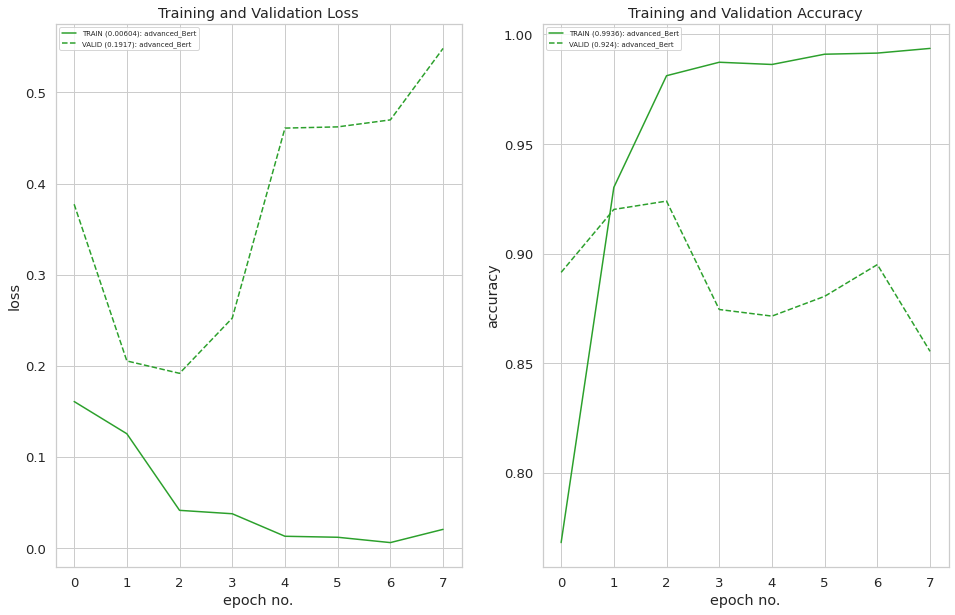

In [18]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['advanced_Bert'],
                   colors=['green'],
                   loss_legend_loc='upper left',
                   acc_legend_loc='upper left',
                   legend_font=7)

In [19]:
with open(os.path.join(os.getcwd(), "data/testing/eval_questions.json")) as file:
   eval_data = json.load(file)

In [20]:
eval_loader = create_data_loader(
    question=eval_data["questions"],
    targets=eval_data["targets"],
    max_len=TokenizerSettings().max_length,
    batch_size=1,
    shuffle=False,
    tokenizer=tokenizer,
)

In [21]:
review_texts, predictions, prediction_probs, real_values = get_predictions(
    bert_base_classifier, eval_loader, device, ModelSettings().binary_thresh
)

In [22]:
def classific_metrics(real_values, predictions, class_names):
    """Returns the classification metrics"""
    logger.info("Test Accuracy : {}".format(accuracy_score(real_values, predictions)))
    logger.info(f"Test Recall : {recall_score(real_values, predictions)}")
    logger.info(f"Test Precision : {precision_score(real_values, predictions)}")
    logger.info(f"Test F1 Score : {f1_score(real_values, predictions)}")
    logger.info("\nClassification Report : ")
    logger.info(classification_report(real_values, predictions, target_names=class_names))

In [23]:
classific_metrics(real_values, predictions, DataSettings().class_names)

2024-04-03 17:38:21,242 - custom_logger - INFO - Test Accuracy : 1.0
2024-04-03 17:38:21,245 - custom_logger - INFO - Test Recall : 1.0
2024-04-03 17:38:21,248 - custom_logger - INFO - Test Precision : 1.0
2024-04-03 17:38:21,252 - custom_logger - INFO - Test F1 Score : 1.0
2024-04-03 17:38:21,252 - custom_logger - INFO - 
Classification Report : 
2024-04-03 17:38:21,262 - custom_logger - INFO -               precision    recall  f1-score   support

      SIMPLE       1.00      1.00      1.00         3
     COMPLEX       1.00      1.00      1.00         4

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7



In [28]:
az_connection = AzureBlobConnection(
    storage_account=env_settings.STORAGE_ACCOUNT,
    client_id=env_settings.CLIENT_ID,
    tenant_id=env_settings.TENANT_ID,
    client_secret=env_settings.SECRET_ID,
)

2024-04-03 17:44:17,775 - custom_logger - INFO - Establishing Connection  with Azure Blob Storage using credentials


In [29]:
logger.info("Uploading to Azure Blob Storage")
az_connection.azblob_upload(
    container_name=env_settings.CONTAINER_NAME,
    root_path=os.getcwd(),
    local_input_path=AzureblobSettings().input_path,
    blob_path=AzureblobSettings().blob_path,
    file_names=[]

)

2024-04-03 17:44:26,512 - custom_logger - INFO - Uploading to Azure Blob Storage
2024-04-03 17:44:26,514 - custom_logger - INFO - Mode of Source selected is Azure Blob for files upload


2024-04-03 17:44:27,891 - custom_logger - INFO - No files specified explicitely, so taking all files 
2024-04-03 17:44:49,686 - custom_logger - INFO - Have successfully pushed file advanced_bert_model.pt in blob classifier_model/ in container abi-insights-copilot-blob
2024-04-03 17:45:10,831 - custom_logger - INFO - Have successfully pushed file base_bert_model.pt in blob classifier_model/ in container abi-insights-copilot-blob


In [30]:
logger.info("Downloading from Azure Blob Storage")
az_connection.azblob_download(
    container_name=env_settings.CONTAINER_NAME,
    root_path=os.getcwd(),
    local_output_path=AzureblobSettings().input_path,
    blob_path=AzureblobSettings().blob_path,
    file_names=[]
)

2024-04-03 17:45:11,115 - custom_logger - INFO - Downloading from Azure Blob Storage
2024-04-03 17:45:11,116 - custom_logger - INFO - Mode of Source selected is Azure Blob


2024-04-03 17:45:11,687 - custom_logger - INFO - downloading the blob to local file
2024-04-03 17:45:11,688 - custom_logger - INFO - Downloaded file at:/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/abi_genai_bert_classifier/models/advanced_bert_model.pt
2024-04-03 17:45:26,990 - custom_logger - INFO - downloading the blob to local file
2024-04-03 17:45:26,991 - custom_logger - INFO - Downloaded file at:/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/abi_genai_bert_classifier/models/base_bert_model.pt
2024-04-03 17:45:42,192 - custom_logger - INFO - All Blobs download process successful, Total count :::2
